In [2]:
# Basic libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight


In [3]:
# 2. Set directories and labels
data_dir = r"C:\Users\LENOVO\Downloads\archive\colored_images"
labels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
label_to_int = {label: idx for idx, label in enumerate(labels)}

In [4]:
# Count images per class
class_counts = {}
for cls in os.listdir(data_dir):  # <- use os.listdir here
    cls_path = os.path.join(data_dir, cls)
    count = len(os.listdir(cls_path))
    class_counts[cls] = count

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Class distribution:
Mild: 370
Moderate: 999
No_DR: 1805
Proliferate_DR: 295
Severe: 193


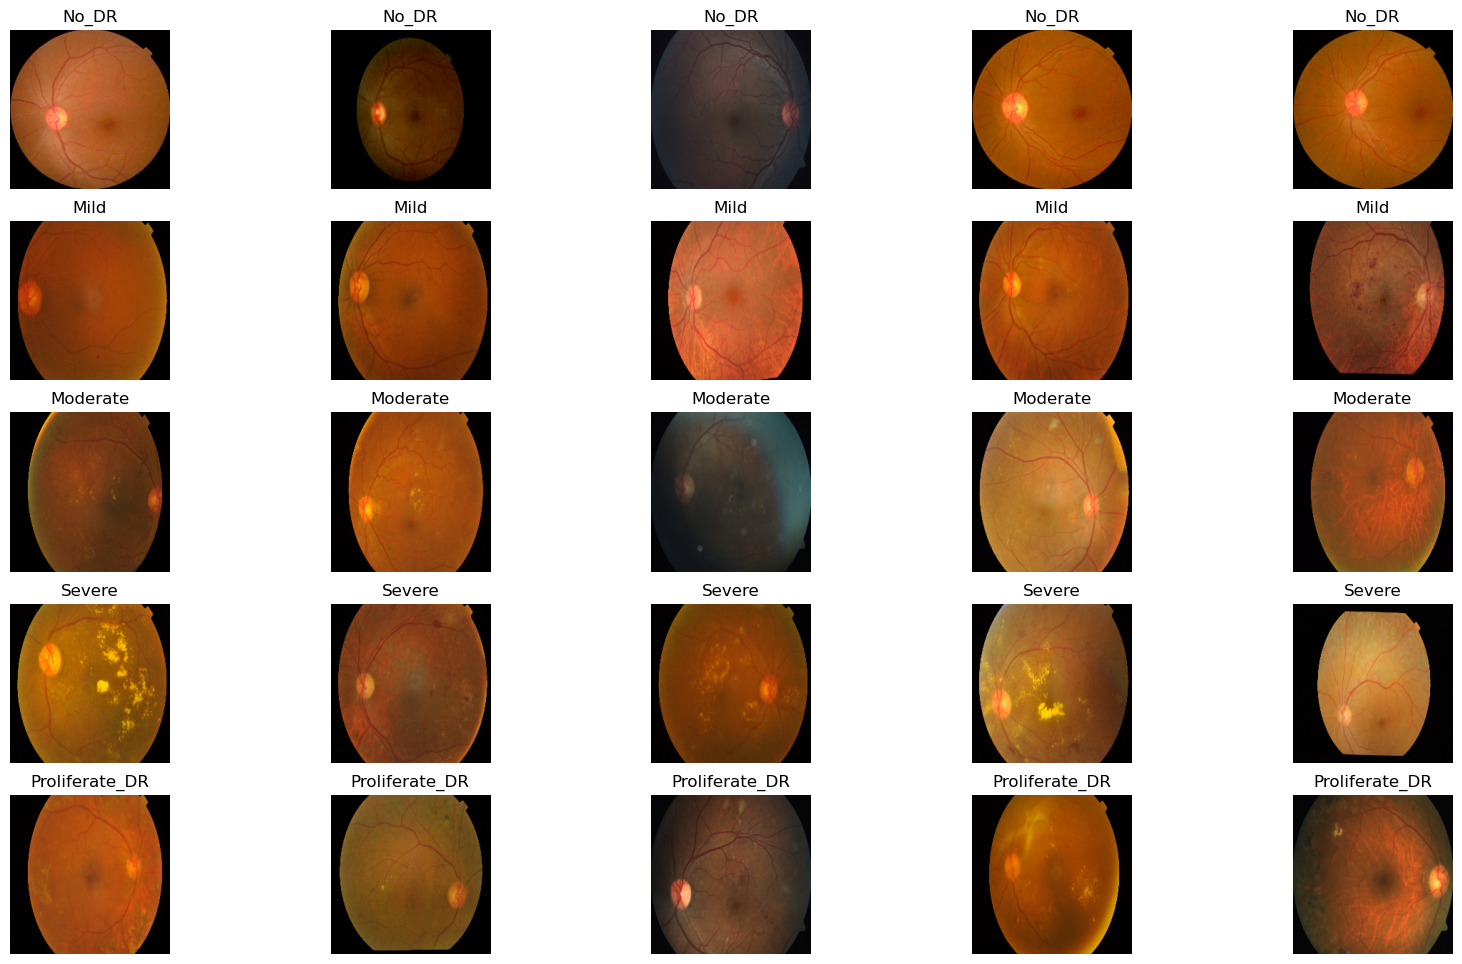

In [5]:
# 3. Preview images using cv2
plt.figure(figsize=(20, 12))
images_per_label = 5
for i, label in enumerate(labels):
    folder_path = os.path.join(data_dir, label)
    for j in range(images_per_label):
        img_file = os.listdir(folder_path)[j]
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)                 # BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        plt.subplot(len(labels), images_per_label, i*images_per_label + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.show()

In [6]:
# =========================
# 4. Compute class weights
# =========================
all_labels = []
for idx, cls in enumerate(labels):
    all_labels.extend([idx]*class_counts[cls])
all_labels = np.array(all_labels)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.4057617728531856), 1: np.float64(1.9794594594594594), 2: np.float64(0.7331331331331331), 3: np.float64(3.7948186528497407), 4: np.float64(2.4827118644067796)}


In [7]:
# 4. Create ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)



In [8]:
# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [9]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Found 2931 images belonging to 5 classes.


In [10]:
# Validation generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 731 images belonging to 5 classes.


In [11]:
# Load ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Build Sequential model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(len(labels), activation='softmax')  # 5 classes
])

In [13]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights

)

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.2282 - loss: 2.2150 - val_accuracy: 0.2722 - val_loss: 1.5036
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.2729 - loss: 1.9120 - val_accuracy: 0.2722 - val_loss: 1.5137
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.2729 - loss: 1.9044 - val_accuracy: 0.2722 - val_loss: 1.5002
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.2729 - loss: 1.9050 - val_accuracy: 0.2722 - val_loss: 1.5140
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.2729 - loss: 1.9047 - val_accuracy: 0.2722 - val_loss: 1.4987
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.2729 - loss: 1.9012 - val_accuracy: 0.2722 - val_loss: 1.5392
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.2729 - loss: 1.9018 - val_accuracy: 0.2722 - val_loss: 1.4835
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.2729 - loss: 1.9001 - val_accu